<a target="_blank" href="https://colab.research.google.com/github/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<a target="_blank" href="https://www.kaggle.com/notebooks/welcome?src=https://github.com/giordamaug/HELP/blob/main/HELPpy/notebooks/prediction.ipynb">
  <img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/>
</a>

### 1. Install HELP from GitHub
Skip this cell if you already have installed HELP.

In [ ]:
!pip install git+https://github.com/giordamaug/HELP.git

### 2. Download the input files
For a chosen tissue (here `Kidney`), download from GitHub the label file (here `Kidney_HELP.csv`, computed as in Example 1) and the attribute files (here BIO `Kidney_BIO.csv`, CCcfs `Kidney_CCcfs_1.csv`, ..., `Kidney_CCcfs_5.csv`, and N2V `Kidney_EmbN2V_128.csv`).  

Skip this step if you already have these input files locally.

In [ ]:
tissue='Kidney'
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_HELP.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_BIO.csv
for i in range(5):
  !wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_CCcfs_{i}.csv
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/{tissue}_EmbN2V_128.csv

Observe that the CCcfs file has been subdivided into 5 separate files for storage limitations on GitHub. 

### 3. Load the input files and process the tissue attributes

+ The label file (`Kidney_HELP.csv`) can be loaded via `read_csv`; its three-class labels (`E`, `aE`, `sNE`) are converted to two-class labels (`E`, `NE`); 

+ The tissue gene attributes are loaded and assembled via `feature_assemble_df` using the downloaded datafiles BIO, CCcfs subdivided into 5 subfiles (`'nchunks': 5`) and embedding. We do not apply missing values fixing (`'fixna': False`), while we do apply data scaling (`'normalize': 'std'`) to the BIO and CCcfs attributes.  

In [4]:
tissue='Lung'
import pandas as pd
from HELPpy.preprocess.loaders import feature_assemble_df
df_y = pd.read_csv(f"{tissue}_HELP.csv", index_col=0)
df_y = df_y.replace({'aE': 'NE', 'sNE': 'NE'})
print(df_y.value_counts(normalize=False))
features = [{'fname': f'{tissue}_BIO.csv', 'fixna' : False, 'normalize': 'std'},
            #{'fname': f'{tissue}_CCcfs.csv', 'fixna' : False, 'normalize': 'std', 'nchunks' : 5},
            #{'fname': f'{tissue}_EmbN2V_128.csv', 'fixna' : False, 'normalize': None}
            ]
df_X, df_y = feature_assemble_df(df_y, features=features, saveflag=False, verbose=True)

label
NE       16696
E         1235
Name: count, dtype: int64
Majority NE 16696 minority E 1235
[Lung_BIO.csv] found 52507 Nan...
[Lung_BIO.csv] Normalization with std ...
17234 labeled genes over a total of 17931
(17234, 25) data input


### 4. Estimate the performance of EGs prediction 

Instantiate the prediction model described in the HELP paper (soft-voting ensemble `VotingSplitClassifier` of `n_voters=10` classifiers) and estimate its performance via 5-fold cross-validation (`k_fold_cv` with `n_splits=5`). Then, print the obtained average performances (`df_scores`)... 

In [7]:
from HELPpy.models.prediction import VotingSplitClassifier, k_fold_cv
clf = VotingSplitClassifier(n_voters=10, n_jobs=-1, random_state=-1)
df_scores, scores, predictions = k_fold_cv(df_X, df_y, clf, n_splits=5, seed=0, verbose=True)
df_scores

{'E': 0, 'NE': 1}
label
NE       16010
E         1224
Name: count, dtype: int64
Classification with VotingSplitClassifier...


5-fold: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


,measure
ROC-AUC,0.9188±0.0065
Accuracy,0.8202±0.0045
BA,0.8387±0.0055
Sensitivity,0.8603±0.0087
Specificity,0.8172±0.0046
MCC,0.4130±0.0083
CM,"[[1053, 171], [2927, 13083]]"


... and those in each fold (`scores`)

In [20]:
scores

,ROC-AUC,Accuracy,BA,Sensitivity,Specificity,MCC,CM
0,0.954258,0.878735,0.889496,0.902041,0.876952,0.522809,"[[221, 24], [394, 2808]]"
1,0.953289,0.873223,0.894068,0.918367,0.869769,0.520189,"[[225, 20], [417, 2785]]"
2,0.955901,0.884827,0.890891,0.897959,0.883823,0.532617,"[[220, 25], [372, 2830]]"
3,0.960578,0.882507,0.895296,0.910204,0.880387,0.533671,"[[223, 22], [383, 2819]]"
4,0.965238,0.880731,0.901747,0.926230,0.877264,0.536883,"[[226, 18], [393, 2809]]"


Show labels, predictions and their probabilities (`predictions`) and save them in a csv file

In [21]:
predictions

,label,prediction,probabilities
gene,,,
A2M,1,1,0.016435
A2ML1,1,1,0.001649
AAGAB,1,1,0.230005
AANAT,1,1,0.002823
AARS2,1,0,0.529173
...,...,...,...
ZSCAN9,1,1,0.004752
ZSWIM6,1,1,0.007049
ZUP1,1,0,0.532555


In [21]:
predictions.to_csv(f"csEGs_{tissue}_EvsNE.csv", index=True)

### 5. Compute TPR for ucsEGs and csEGs

Read the result files for ucsEGs (`ucsEG_Kidney.txt`) and csEGs (`csEGs_Kidney_EvsNE.csv`) already computed for the tissue, compute the TPRs (tpr) and show their bar plot. 

zsh:1: command not found: wget
zsh:1: command not found: wget
ucsEG Kidney TPR = 0.780 (46/59) ucsEG Kidney TPR =  0.897 (1114/1242)


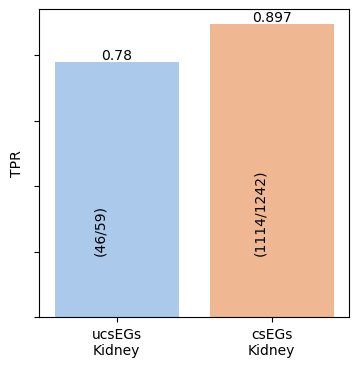

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
labels = []
data = []
tpr = []
genes = {}
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/ucsEG_{tissue}.txt
ucsEGs = pd.read_csv(f"ucsEG_{tissue}.txt", index_col=0, header=None).index.values
!wget https://raw.githubusercontent.com/giordamaug/HELP/main/data/csEGs_{tissue}_EvsNE.csv
predictions = pd.read_csv(f"csEGs_{tissue}_EvsNE.csv", index_col=0)
indices = np.intersect1d(ucsEGs, predictions.index.values)
preds = predictions.loc[indices]
num1 = len(preds[preds['label'] == preds['prediction']])
den1 = len(preds[preds['label'] == 0])
den2 = len(predictions[predictions['label'] == 0])
num2 = len(predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])])
labels += [f"ucsEGs\n{tissue}", f"csEGs\n{tissue}"]
data += [float(f"{num1 /den1:.3f}"), float(f"{num2 /den2:.3f}")]
tpr += [f"{num1}/{den1}", f"{num2}/{den2}"]
genes[f'ucsEGs_{tissue}_y'] = preds[preds['label'] == preds['prediction']].index.values
genes[f'ucsEGs_{tissue}_n'] = preds[preds['label'] != preds['prediction']].index.values
genes[f'csEGs_{tissue}_y'] = predictions[(predictions['label'] == 0) & (predictions['label'] == predictions['prediction'])].index.values
genes[f'csEGs_{tissue}_n'] = predictions[(predictions['label'] == 0) & (predictions['label'] != predictions['prediction'])].index.values
print(f"ucsEG {tissue} TPR = {num1 /den1:.3f} ({num1}/{den1}) ucsEG {tissue} TPR =  {num2/den2:.3f} ({num2}/{den2})")

f, ax = plt.subplots(figsize=(4, 4))
palette = sns.color_palette("pastel", n_colors=2)
sns.barplot(y = data, x = labels, ax=ax, hue= data, palette = palette, orient='v', legend=False)
ax.set_ylabel('TPR')
ax.set(yticklabels=[])
for i,l,t in zip(range(4),labels,tpr):
    ax.text(-0.15 + (i * 1.03), 0.2, f"({t})", rotation='vertical')
for i in ax.containers:
    ax.bar_label(i,)

This code can be used to produce Fig 5(B) of the HELP paper by executing an iteration cycle for both `kidney` and `lung` tissues.

At the end, we print the list of ucs_EGs for the tissue.

In [19]:
genes[f'ucsEGs_{tissue}_y']

array(['ACTG1', 'ACTR6', 'ARF4', 'ARPC4', 'CDK6', 'CHMP7', 'COPS3',
       'DCTN3', 'DDX11', 'DDX52', 'EMC3', 'EXOSC1', 'GEMIN7', 'GET3',
       'HGS', 'HTATSF1', 'KIF4A', 'MCM10', 'MDM2', 'METAP2', 'MLST8',
       'NCAPH2', 'NDOR1', 'OXA1L', 'PFN1', 'PIK3C3', 'PPIE', 'PPP1CA',
       'PPP4R2', 'RAB7A', 'RAD1', 'RBM42', 'RBMX2', 'RTEL1', 'SNRPB2',
       'SPTLC1', 'SRSF10', 'TAF1D', 'TMED10', 'TMED2', 'UBA5', 'UBC',
       'UBE2D3', 'USP10', 'VPS52', 'YWHAZ'], dtype=object)